# Data set and Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, when
from pyspark.sql.types import FloatType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Telecom Churn Prediction") \
    .getOrCreate()

# Load the dataset into a Spark DataFrame
data = spark.read.csv('/content/drive/MyDrive/datasets/telecom_churn.csv', header=True, inferSchema=True)

# Display the first few rows of the DataFrame to confirm successful loading
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [ ]:
print("Shape: ", (data.count(), len(data.columns)))

Shape:  (7043, 21)


In [ ]:
# Summary statistics
data.describe().show()

+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043|   7043|      7043|     

In [ ]:
# Types of Variables
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [ ]:
# Summary statistics for specific numerical variables
data.describe(['tenure', 'MonthlyCharges', 'TotalCharges']).show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7043|
|   mean| 32.37114865824223| 64.76169246059922|2283.3004408418697|
| stddev|24.559481023094442|30.090047097678482| 2266.771361883145|
|    min|                 0|             18.25|                  |
|    max|                72|            118.75|             999.9|
+-------+------------------+------------------+------------------+



In [ ]:
# Class statistics of categorical variables
data.groupby("Churn").count().show()


+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [ ]:
# Unique Classes
data.select("Churn").distinct().show()

+-----+
|Churn|
+-----+
|   No|
|  Yes|
+-----+



In [ ]:
#Time Spent
data.groupby("Churn").agg({"tenure": "mean"}).show()

+-----+------------------+
|Churn|       avg(tenure)|
+-----+------------------+
|   No| 37.56996521066873|
|  Yes|17.979133226324237|
+-----+------------------+



In [ ]:
#Selection and summary statistics of all numeric variables
num_cols = [col[0] for col in data.dtypes if col[1] != 'string']
data.select(num_cols).describe().show()


+-------+------------------+------------------+------------------+
|summary|     SeniorCitizen|            tenure|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7043|
|   mean|0.1621468124378816| 32.37114865824223| 64.76169246059922|
| stddev|0.3686116056100135|24.559481023094442|30.090047097678482|
|    min|                 0|                 0|             18.25|
|    max|                 1|                72|            118.75|
+-------+------------------+------------------+------------------+



In [ ]:
#Selection and summary of all categorical variables
cat_cols = [col[0] for col in data.dtypes if col[1] == 'string']
data.select(cat_cols).describe().show()

+-------+----------+------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+-----+
|summary|customerID|gender|Partner|Dependents|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|      TotalCharges|Churn|
+-------+----------+------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+-----+
|  count|      7043|  7043|   7043|      7043|        7043|         7043|           7043|          7043|        7043|            7043|       7043|       7043|           7043|          7043|            7043|                7043|              

In [ ]:
data.describe().show()

+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043|   7043|      7043|     

In [ ]:
# mean of numerical variables relative to the target variable
for col in [col.lower() for col in num_cols]:
    data.groupby("Churn").agg({col: "mean"}).show()

+-----+-------------------+
|Churn| avg(seniorcitizen)|
+-----+-------------------+
|   No|0.12872052570545034|
|  Yes| 0.2546816479400749|
+-----+-------------------+

+-----+------------------+
|Churn|       avg(tenure)|
+-----+------------------+
|   No| 37.56996521066873|
|  Yes|17.979133226324237|
+-----+------------------+

+-----+-------------------+
|Churn|avg(monthlycharges)|
+-----+-------------------+
|   No|   61.2651236953999|
|  Yes|   74.4413322632423|
+-----+-------------------+



# Data Preprocessing

**Detect and Handle Missing Values**

In [ ]:
# Counting missing values in each column
missing_values = data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns])
missing_values.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

The DataFrame appears to have no missing values in any of its columns, as indicated by all counts being 0.

In [ ]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

**Detect and Handle Outliers**

In [ ]:
from pyspark.sql.functions import col, lit, when

# Column to check for outliers
column = 'MonthlyCharges'

# Calculate the lower and upper quartiles and the IQR
quantiles = data.stat.approxQuantile(column, [0.25, 0.75], 0.05)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_filtered = data.filter(
    (col(column) >= lit(lower_bound)) &
    (col(column) <= lit(upper_bound))
)

# Optionally, cap outliers instead of removing them
data_capped = data.withColumn(
    "MonthlyChargesCapped",
    when(col(column) < lit(lower_bound), lit(lower_bound))
    .when(col(column) > lit(upper_bound), lit(upper_bound))
    .otherwise(col(column))
)

# Show results after filtering and capping
data_filtered.select(column).show()
data_capped.select(column, "MonthlyChargesCapped").show()


+--------------+
|MonthlyCharges|
+--------------+
|         29.85|
|         56.95|
|         53.85|
|          42.3|
|          70.7|
|         99.65|
|          89.1|
|         29.75|
|         104.8|
|         56.15|
|         49.95|
|         18.95|
|        100.35|
|         103.7|
|         105.5|
|        113.25|
|         20.65|
|         106.7|
|          55.2|
|         90.05|
+--------------+
only showing top 20 rows

+--------------+--------------------+
|MonthlyCharges|MonthlyChargesCapped|
+--------------+--------------------+
|         29.85|               29.85|
|         56.95|               56.95|
|         53.85|               53.85|
|          42.3|                42.3|
|          70.7|                70.7|
|         99.65|               99.65|
|          89.1|                89.1|
|         29.75|               29.75|
|         104.8|               104.8|
|         56.15|               56.15|
|         49.95|               49.95|
|         18.95|               18.

This code calculates the lower and upper bounds using the interquartile range (IQR) method, then filters out outliers from the 'MonthlyCharges' column based on these bounds. Optionally, it caps outliers by replacing them with the nearest bound. The first output displays 'MonthlyCharges' values without outliers, while the second output adds a new column 'MonthlyChargesCapped' showing capped values, ensuring they fall within the acceptable range.

**One-hot Encoding**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define categorical and numeric columns
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Add or remove based on your dataset
from pyspark.sql.functions import col

# Convert "TotalCharges" column to float type
data = data.withColumn("TotalCharges", col("TotalCharges").cast("float"))
# Index and encode categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index") for c in categorical_columns]
encoders = [OneHotEncoder(inputCols=[f"{c}_index"], outputCols=[f"{c}_encoded"]) for c in categorical_columns]

# Assemble all features into one vector column

assembler = VectorAssembler(inputCols=[f"{c}_encoded" for c in categorical_columns] + numeric_columns, outputCol="features", handleInvalid="skip")

# Convert target variable 'Churn' into numerical form
label_indexer = StringIndexer(inputCol="Churn", outputCol="label")

# Define the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])
# Fit the pipeline to the DataFrame
pipeline_model = pipeline.fit(data)

# Transform the DataFrame using the pipeline
df_transformed = pipeline_model.transform(data)

# Display the updated DataFrame
df_transformed.show()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+--------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+--------------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|Pho

The code utilizes PySpark to transform categorical columns in a DataFrame into numerical format. Initially, a list named categorical_columns is created to store the names of categorical columns. Then, StringIndexer and OneHotEncoder transformers are initialized for each categorical column. These transformers convert categorical values into numerical indices and sparse vectors, respectively. Subsequently, a Pipeline is constructed with all transformers added to it to ensure sequential execution of transformation steps. The Pipeline is fitted to the data, and transformations are applied. The output displays the original and transformed DataFrame, illustrating how categorical values are replaced with numerical indices and one-hot encoded vectors. This process enables efficient handling of categorical data while preserving the meaningful information contained within them.

**Correlation between numeric features**

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# Convert 'TotalCharges' to double type, handling non-numeric entries
data = data.withColumn("TotalCharges",
                       when(col("TotalCharges").cast(DoubleType()).isNull(), None)
                       .otherwise(col("TotalCharges").cast(DoubleType())))

# Drop rows with any null values in the columns of interest to ensure correlation calculations are accurate
data = data.na.drop(subset=["tenure", "MonthlyCharges", "TotalCharges"])

# List of numerical columns for which you want to calculate correlations
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Calculate pairwise correlations between all numerical columns
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        col1 = numerical_columns[i]
        col2 = numerical_columns[j]
        correlation = data.stat.corr(col1, col2)
        print(f"Correlation between {col1} and {col2}: {correlation:.2f}")


Correlation between tenure and MonthlyCharges: 0.25
Correlation between tenure and TotalCharges: 0.83
Correlation between MonthlyCharges and TotalCharges: 0.65


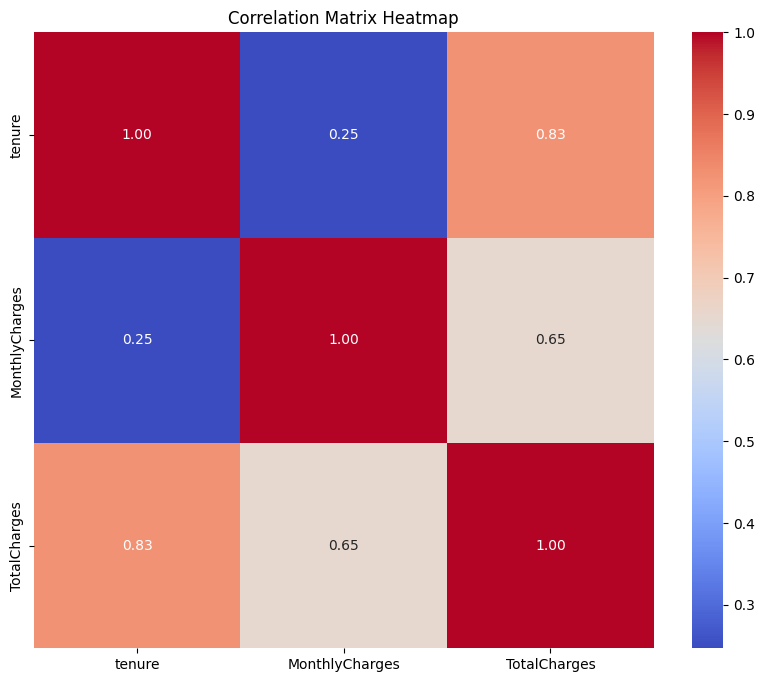

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# List of numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize an empty DataFrame to store the correlation values
corr_matrix = pd.DataFrame(index=numerical_columns, columns=numerical_columns)

# Compute the correlation matrix
for i in range(len(numerical_columns)):
    for j in range(i, len(numerical_columns)):
        col1 = numerical_columns[i]
        col2 = numerical_columns[j]
        corr = data.stat.corr(col1, col2)
        corr_matrix.at[col1, col2] = corr
        corr_matrix.at[col2, col1] = corr  # Symmetric property

# Convert the correlation matrix to numeric type for plotting
corr_matrix = corr_matrix.astype(float)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


The code employs PySpark to calculate pairwise correlations between specified numerical columns ('tenure', 'MonthlyCharges', 'TotalCharges') in a DataFrame. The output indicates the pairwise correlations between the specified numerical columns in a DataFrame. A correlation value close to 1 suggests a strong positive relationship, while a value close to -1 indicates a strong negative relationship. A correlation of 0 implies no linear relationship. For example, the output shows a moderate positive correlation between tenure and MonthlyCharges (0.25), a strong positive correlation between tenure and TotalCharges (0.83), and a moderate positive correlation between MonthlyCharges and TotalCharges (0.65).

**Scaling Numeric Features**

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline

# Define the numerical columns you want to scale
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Adjust this list based on your dataset's columns

# Assemble the numerical columns into a single vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")

# Initialize the StandardScaler
standard_scaler = StandardScaler(inputCol="features", outputCol="standard_scaled_features", withStd=True, withMean=True)

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="min_max_scaled_features")

# Build the pipeline with both scalers
pipeline = Pipeline(stages=[assembler, standard_scaler, min_max_scaler])

# Fit the pipeline to the data and transform the data
scaled_data = pipeline.fit(data).transform(data)

# Show the original features and their scaled versions
scaled_data.select("features", "standard_scaled_features", "min_max_scaled_features").show(truncate=False)


+-------------------------------+--------------------------------------------------------------+---------------------------------------------------------------+
|features                       |standard_scaled_features                                      |min_max_scaled_features                                        |
+-------------------------------+--------------------------------------------------------------+---------------------------------------------------------------+
|[1.0,29.85,29.850000381469727] |[-1.280157003542847,-1.1616113317725878,-0.9941233940394837]  |[0.0,0.11542288557213931,0.001275098245151048]                 |
|[34.0,56.95,1889.5]            |[0.0642981128781043,-0.26085936993009123,-0.17372746444337342]|[0.4647887323943662,0.3850746268656717,0.2158666100576614]     |
|[2.0,53.85,108.1500015258789]  |[-1.2394159394088786,-0.36389741722572744,-0.9595808713930605]|[0.014084507042253521,0.35422885572139307,0.010310408988541875]|
|[45.0,42.3,1840.75]            |[

The output displays the original numerical features alongside their scaled versions using both standard scaling and min-max scaling techniques. Standard scaling transforms the data to have a mean of 0 and a standard deviation of 1, preserving the distribution's shape. Min-max scaling scales the data to a predefined range, typically between 0 and 1, preserving the relative relationships between data points. This allows for normalization of the features, which can be beneficial.

**Feature Engineering**

In [ ]:
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.sql.functions import when, col

# Interaction term between tenure and monthly charges
data = data.withColumn("Tenure_MonthlyCharges", col("tenure") * col("MonthlyCharges"))

# Binary feature for high total charges
threshold = 5000
data = data.withColumn("HighTotalCharges", when(col("TotalCharges") > threshold, 1).otherwise(0))

# Combining streaming TV and movies into one binary feature
data = data.withColumn("StreamingServices", when((col("StreamingTV") == "Yes") | (col("StreamingMovies") == "Yes"), 1).otherwise(0))

# Polynomial expansion of 'tenure'
assembler = VectorAssembler(inputCols=["tenure"], outputCol="tenure_features")
polyExpansion = PolynomialExpansion(degree=2, inputCol="tenure_features", outputCol="tenure_expanded")
data = assembler.transform(data)
data = polyExpansion.transform(data)

# Simplifying PaymentMethod into binary
data = data.withColumn("ElectronicPayment", when(col("PaymentMethod").isin(["Electronic check", "Credit card (automatic)", "Bank transfer (automatic)"]), 1).otherwise(0))

# Select and show new features
data.select("Tenure_MonthlyCharges", "HighTotalCharges", "StreamingServices", "tenure_expanded", "ElectronicPayment").show()


+---------------------+----------------+-----------------+---------------+-----------------+
|Tenure_MonthlyCharges|HighTotalCharges|StreamingServices|tenure_expanded|ElectronicPayment|
+---------------------+----------------+-----------------+---------------+-----------------+
|                29.85|               0|                0|      [1.0,1.0]|                1|
|   1936.3000000000002|               0|                0|  [34.0,1156.0]|                0|
|                107.7|               0|                0|      [2.0,4.0]|                0|
|   1903.4999999999998|               0|                0|  [45.0,2025.0]|                1|
|                141.4|               0|                0|      [2.0,4.0]|                1|
|                797.2|               0|                1|     [8.0,64.0]|                1|
|   1960.1999999999998|               0|                1|   [22.0,484.0]|                1|
|                297.5|               0|                0|   [10.0,100


The output presents newly engineered features derived from existing data columns. It includes:

Interaction Term: Multiplies tenure by monthly charges.

Binary Feature: Creates a binary indicator for whether total charges are above a set threshold.

Combining Features: Merges related services into one indicator.

Polynomial Features: Expands tenure into its polynomial terms to capture non-linearity.

Simplifying Categories: Reduces the payment method categories into a simpler form.

These engineered features aim to capture more nuanced relationships within the data and provide simplified representations for modeling purposes, potentially enhancing the predictive power of machine learning algorithms.

# Data Visualization

In [ ]:
pandas_df = data.toPandas()

In [ ]:
pandas_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure_MonthlyCharges,HighTotalCharges,StreamingServices,tenure_features,tenure_expanded,ElectronicPayment
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.850000,No,29.85,0,0,[1.0],"[1.0, 1.0]",1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.500000,No,1936.30,0,0,[34.0],"[34.0, 1156.0]",0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.150002,Yes,107.70,0,0,[2.0],"[2.0, 4.0]",0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.750000,No,1903.50,0,0,[45.0],"[45.0, 2025.0]",1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.649994,Yes,141.40,0,0,[2.0],"[2.0, 4.0]",1


**1. Churn Rate Visualization**

<ipython-input-24-ea31a65ef57b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='pastel')


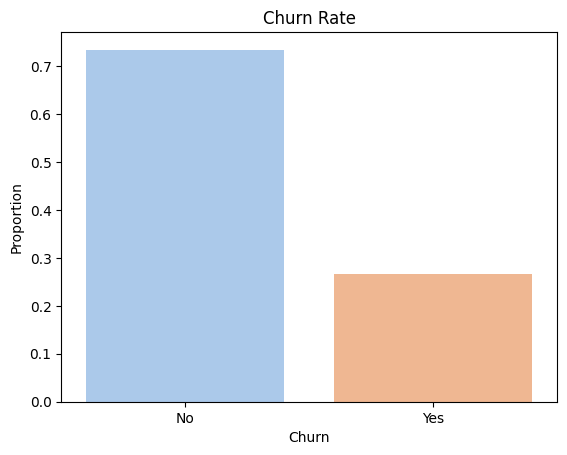

In [ ]:
# Churn rate
churn_rate = pandas_df['Churn'].value_counts(normalize=True)
sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='pastel')
plt.title('Churn Rate')
plt.ylabel('Proportion')
plt.show()

The bar chart illustrates the churn rate, comparing the proportion of customers who did not churn versus those who did. The blue bar represents customers who did not churn, making up a significant majority at approximately 0.7 (70%). The orange bar represents customers who churned, constituting a smaller fraction at around 0.2 (20%). This visual representation suggests that a larger proportion of the customers have remained with the service or company, while a smaller percentage have opted to leave.

**2. Customer Demographics: Gender and Senior Citizen Status**

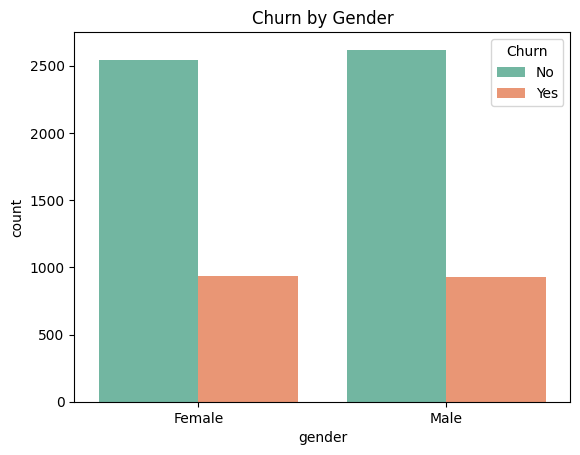

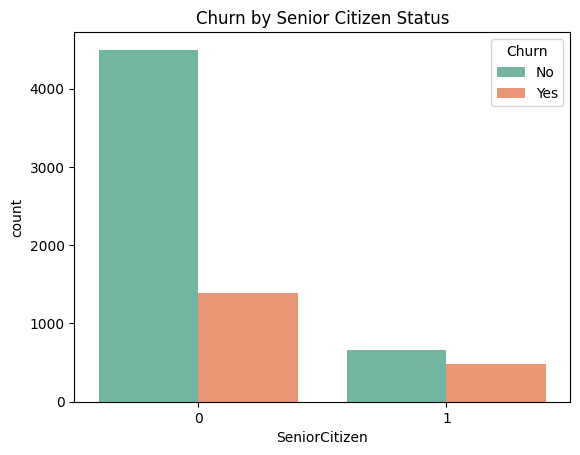

In [ ]:
# Gender and churn
sns.countplot(x='gender', hue='Churn', data=pandas_df, palette='Set2')
plt.title('Churn by Gender')
plt.show()

# Senior Citizen status and churn
sns.countplot(x='SeniorCitizen', hue='Churn', data=pandas_df, palette='Set2')
plt.title('Churn by Senior Citizen Status')
plt.show()

 The bar chart titled "Churn by Gender" presents the churn distribution across female and male customers. For both genders, the chart shows a higher count of customers who did not churn (green bars) compared to those who did churn (orange bars). The count for non-churning customers is above 2000 for both genders, while the churn count is significantly lower, around 500 for females and slightly higher for males. This indicates that regardless of gender, the majority of customers continue to use the service, with a smaller fraction opting out.

The chart "Churn by Senior Citizen Status" illustrates churn differences between senior citizens and non-seniors. Non-seniors have a higher total count with the majority not churning. For seniors, the numbers of churning and non-churning customers are relatively equal, suggesting a higher churn propensity among seniors compared to non-seniors, despite their overall lower numbers. This indicates that senior citizens are more likely to discontinue services than their younger counterparts.

**3. Tenure and Monthly Charges Distribution**

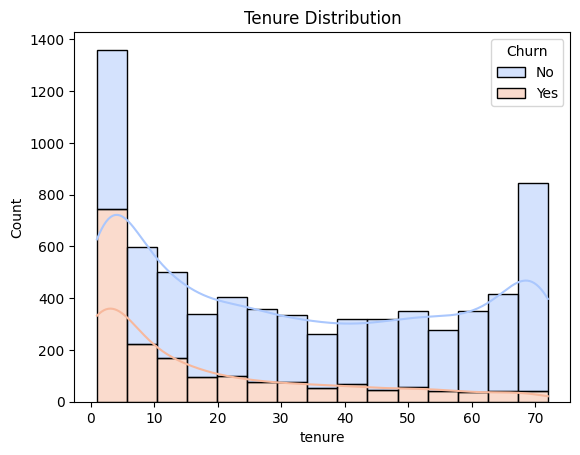

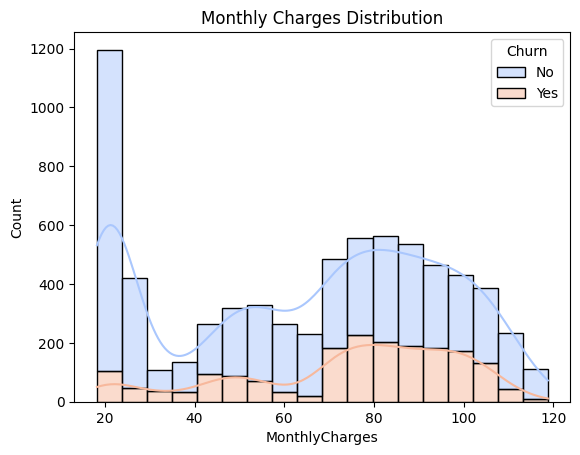

In [ ]:
# Distribution of tenure with churn
sns.histplot(data=pandas_df, x='tenure', hue='Churn', multiple='stack', kde=True, palette='coolwarm')
plt.title('Tenure Distribution')
plt.show()

# Distribution of Monthly Charges
sns.histplot(data=pandas_df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, palette='coolwarm')
plt.title('Monthly Charges Distribution')
plt.show()

The first chart, "Tenure Distribution," shows customer churn based on tenure length. A large number of customers churn within the first 10 months, then it gradually decreases. Customers with longer tenures tend to stay, indicated by the large peaks around the 0 and 70-month marks for non-churners.

The second chart, "Monthly Charges Distribution," indicates churn relative to monthly charges. High churn is evident at lower charge levels and peaks again at higher charge ranges, suggesting sensitivity to pricing among customers, particularly at the extremes of the charge spectrum.

**4. Box Plot for Monthly Charges by Churn Status**

<ipython-input-27-a49196b4b63c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=pandas_df, palette='light:#5A9')


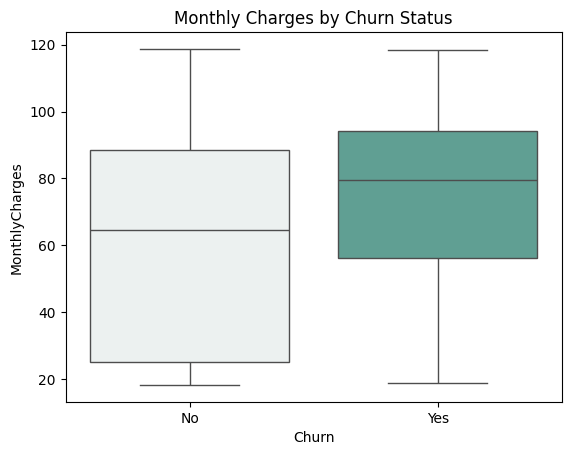

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=pandas_df, palette='light:#5A9')
plt.title('Monthly Charges by Churn Status')
plt.show()

The first chart, "Tenure Distribution," shows customer churn based on tenure length. A large number of customers churn within the first 10 months, then it gradually decreases. Customers with longer tenures tend to stay, indicated by the large peaks around the 0 and 70-month marks for non-churners.

The second chart, "Monthly Charges Distribution," indicates churn relative to monthly charges. High churn is evident at lower charge levels and peaks again at higher charge ranges, suggesting sensitivity to pricing among customers, particularly at the extremes of the charge spectrum.

**5. Churn Rate by Internet Service Type**

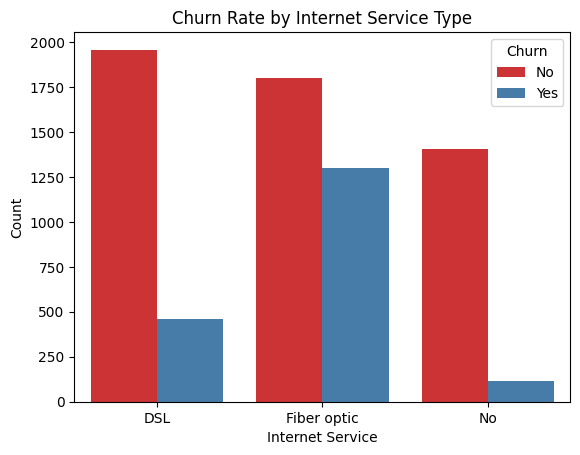

In [ ]:
sns.countplot(x='InternetService', hue='Churn', data=pandas_df, palette='Set1')
plt.title('Churn Rate by Internet Service Type')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.show()

The bar chart "Churn Rate by Internet Service Type" compares customer churn across different types of internet services: DSL, Fiber optic, and No internet service. Notably, the churn for Fiber optic users is significantly higher than for DSL users, despite a similar number of customers not churning. For those without internet service, the churn is notably lower, suggesting higher satisfaction or fewer issues leading to churn among these customers. The data indicates that customers with Fiber optic service are more likely to churn compared to other groups.

**6. Pair Plot of Selected Features**

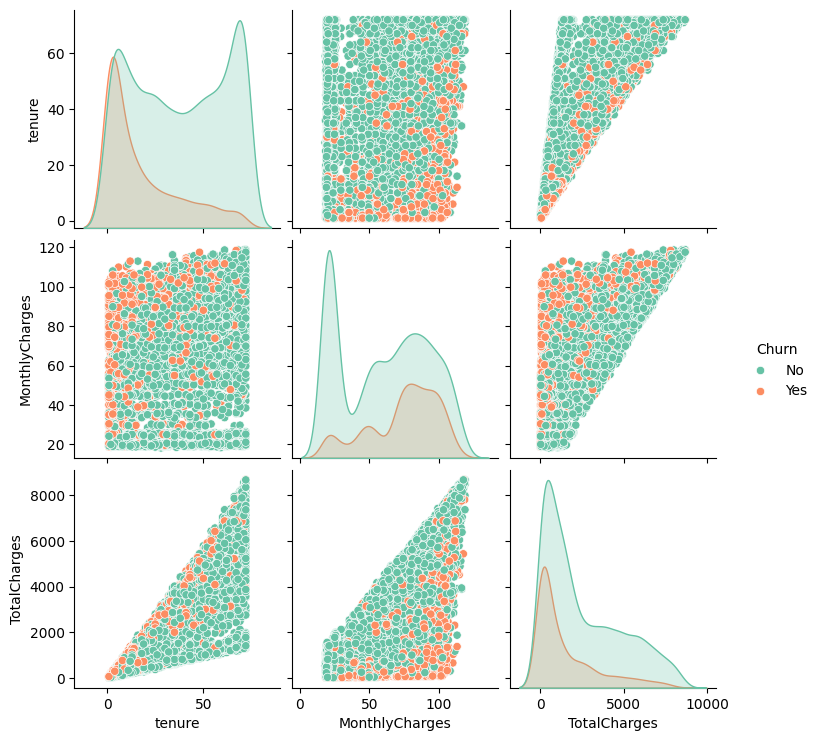

In [ ]:
selected_features = pandas_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]
sns.pairplot(selected_features, hue='Churn', palette='Set2', diag_kind='kde')
plt.show()

The visualization analyzes customer churn across tenure, monthly charges, and total charges using density plots, scatter plots, and marginal histograms:

Tenure: High churn among new customers, with churn decreasing as tenure increases.

Monthly Charges: Peaks in churn at both lower and higher charges, indicating price sensitivity.

Total Charges: Higher churn among customers with lower total expenditures, regardless of tenure.

These patterns suggest that newer customers, those experiencing higher monthly charges, and those with lower total spending are more likely to churn. The visual data effectively highlights the key factors influencing customer retention and turnover.

**7. Churn Distribution by Contract Type**

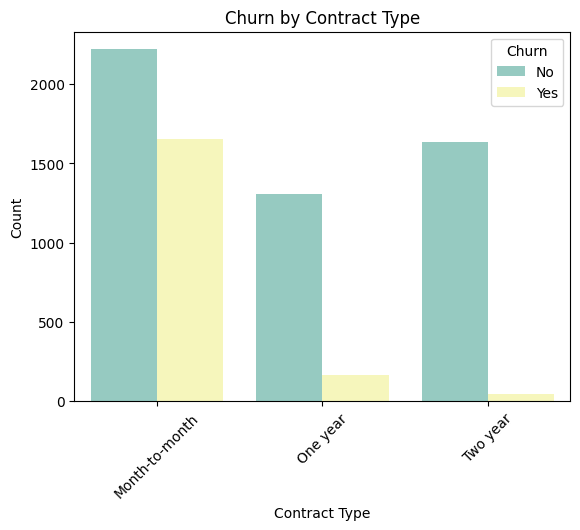

In [ ]:
sns.countplot(x='Contract', hue='Churn', data=pandas_df, palette='Set3')
plt.title('Churn by Contract Type')
plt.xticks(rotation=45)
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

The bar chart, "Churn by Contract Type," compares customer churn across three contract types: month-to-month, one-year, and two-year. The chart shows the highest churn rate for customers on month-to-month contracts, followed by one-year and two-year contracts, respectively. The count of customers not churning also decreases with longer contract durations. This indicates that shorter commitment periods, such as month-to-month contracts, are associated with higher churn rates, suggesting that longer commitments may encourage customer retention.

**8. Density Plot of Monthly Charges by Churn Status**

<ipython-input-31-4883fec06761>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pandas_df[pandas_df['Churn'] == 'Yes']['MonthlyCharges'], label='Churned', shade=True, color="r")
<ipython-input-31-4883fec06761>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pandas_df[pandas_df['Churn'] == 'No']['MonthlyCharges'], label='Not Churned', shade=True, color="g")


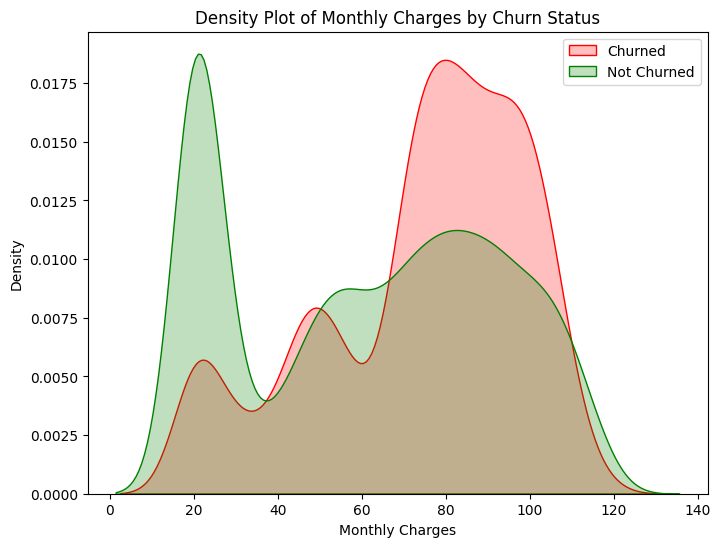

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(pandas_df[pandas_df['Churn'] == 'Yes']['MonthlyCharges'], label='Churned', shade=True, color="r")
sns.kdeplot(pandas_df[pandas_df['Churn'] == 'No']['MonthlyCharges'], label='Not Churned', shade=True, color="g")
plt.title('Density Plot of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')
plt.legend()
plt.show()

The density plot of "Monthly Charges by Churn Status" reveals distinct patterns in churn behavior based on monthly charges. There are two prominent peaks in the churned distribution (red): one at lower charges around  20andanotherathigherchargesnear 100. These peaks suggest that customers at both low and high price points are prone to churn. Conversely, the density for those who have not churned (green) is more evenly spread across the charge range, peaking around  20andagainnear 80, indicating a more stable customer base in these price segments. This illustrates that both extremes of the pricing spectrum influence churn rates differently.

**9. Churn Rate by Multiple Lines Service**

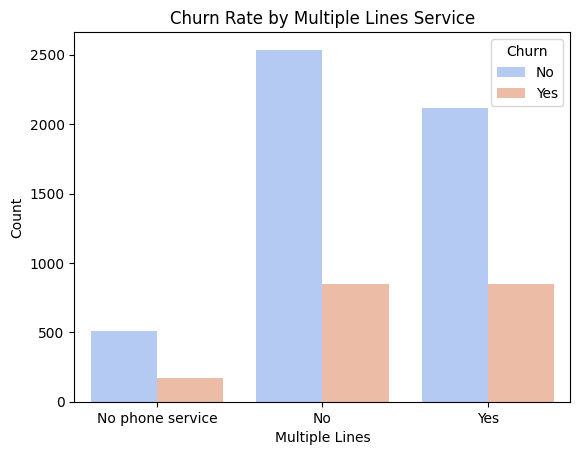

In [ ]:
sns.countplot(x='MultipleLines', hue='Churn', data=pandas_df, palette='coolwarm')
plt.title('Churn Rate by Multiple Lines Service')
plt.xlabel('Multiple Lines')
plt.ylabel('Count')
plt.show()

The bar chart titled "Churn Rate by Multiple Lines Service" illustrates customer churn based on their phone service configuration. Three categories are displayed: "No phone service," "No" (indicating a single line), and "Yes" (indicating multiple lines).

No phone service: Shows a small number of customers with a relatively low churn rate.

No (single line): Represents a substantial number of customers with a moderate churn rate.

Yes (multiple lines): Slightly more customers than the single line category, with a churn rate marginally lower than that of single-line users, indicating that customers with multiple lines are slightly more likely to stay.

Overall, the chart suggests that customers with multiple lines are less likely to churn compared to those with a single line, highlighting potential benefits in service retention with multiple line offerings.

**10. Churn Rate by Tech Support and Contract Type**

<ipython-input-33-3c9bba154d7b>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Contract', y=(pandas_df['Churn'] == 'Yes').astype(int), hue='TechSupportBinary', data=pandas_df, ci=None, palette='Set1')


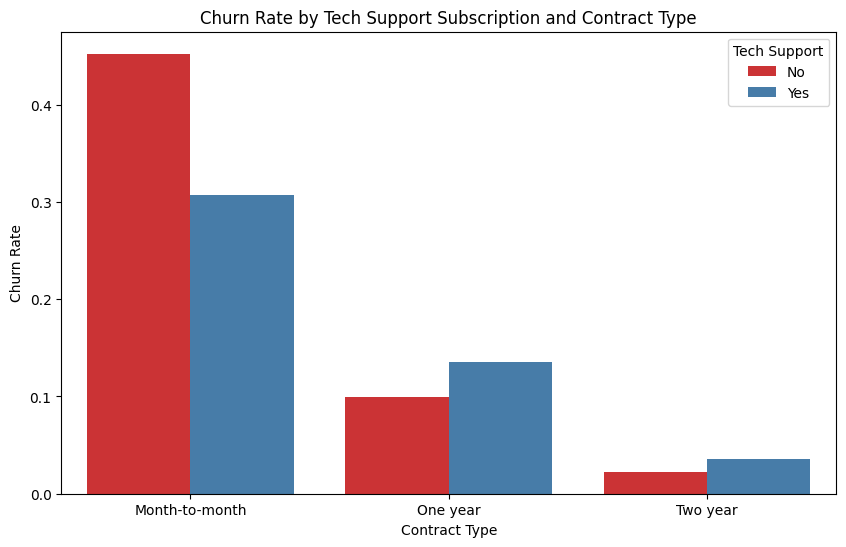

In [ ]:
# Create a simpler category for tech support
pandas_df['TechSupportBinary'] = pandas_df['TechSupport'].apply(lambda x: 'Yes' if x == 'Yes' else 'No')

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Contract', y=(pandas_df['Churn'] == 'Yes').astype(int), hue='TechSupportBinary', data=pandas_df, ci=None, palette='Set1')
plt.title('Churn Rate by Tech Support Subscription and Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.legend(title='Tech Support')
plt.show()

The bar chart titled "Churn Rate by Tech Support Subscription and Contract Type" reveals how tech support subscription impacts churn rates across different contract types: month-to-month, one year, and two years.

Month-to-month contracts: Shows the highest churn rates, with customers without tech support (red bar) experiencing substantially higher churn than those with tech support (blue bar).

One-year contracts: Displays a reduced churn rate for both groups compared to month-to-month, yet customers without tech support still show a higher churn rate than those with support.

Two-year contracts: Exhibits the lowest churn rates overall, with a very minimal churn for customers with tech support.

# Model Development

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split the dataset into training and test sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=123)

# Define the Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Train the model
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='label')
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy:", accuracy)

Test Accuracy: 0.8362126131287728


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision:", precision)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall:", recall)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1-score:", f1_score)


Test Accuracy: 0.8333293545957069
Precision: 0.7693153962309678
Recall: 0.7888810696692471
F1-score: 0.7669315976833183


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Area under ROC curve
evaluator_roc = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
auc_roc = evaluator_roc.evaluate(predictions)
print("Area under ROC:", auc_roc)

# Area under precision-recall curve
evaluator_pr = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
auc_pr = evaluator_pr.evaluate(predictions)
print("Area under PR:", auc_pr)


Area under ROC: 0.8333293545957069
Area under PR: 0.6208377453432069


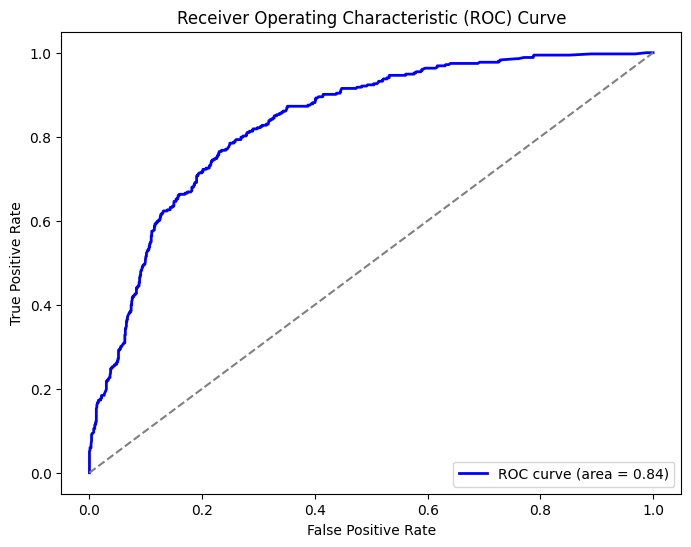

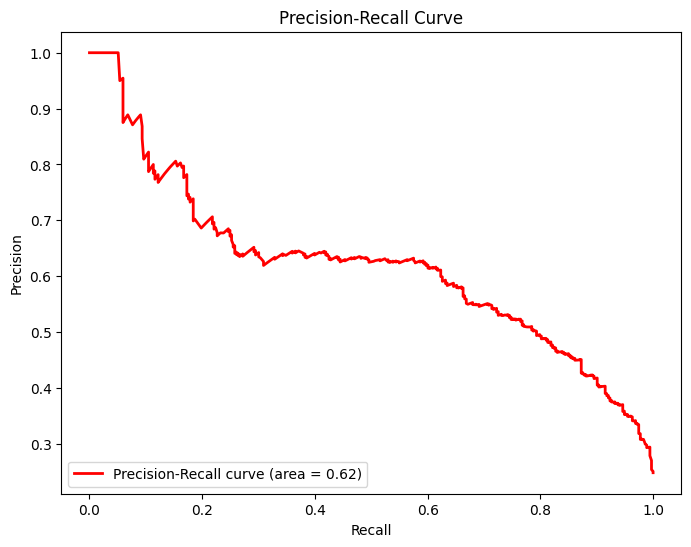

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Get the probability of the positive class (churn = 1) from predictions
probs = predictions.select('probability').rdd.map(lambda row: row['probability'][1]).collect()

# Get the true labels
labels = predictions.select('label').rdd.map(lambda row: float(row['label'])).collect()

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels, probs)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(labels, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Show plots
plt.show()


The ROC curve for the model shows a good performance with an area of 0.84, indicating strong discriminative ability between positive and negative classes. The Precision-Recall curve, however, reveals a lower area of 0.62, suggesting the model struggles more with class imbalance, impacting its precision and recall balance. With an AUC of 0.83, the model performs well overall, but precision at lower recall levels needs improvement, as evidenced by the declining precision in the Precision-Recall curve.

In [1]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Define RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Define parameter grid for Random Search with reduced search space
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 15]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Reduce the number of folds
numFolds = 3

# Increase parallelism
parallelism = 4

# Define CrossValidator with modified settings
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=numFolds,
                          parallelism=parallelism)

# Perform cross-validation with modified settings
cvModel = crossval.fit(train_data)

# Make predictions on the test data
predictions = cvModel.transform(test_data)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

precision = evaluator.evaluate(predictions)
print("Precision:" , precision )

Recall= evaluator.evaluate(predictions)
print("Recall: ", recall)

F1Score= evaluator.evaluate(predictions)
print("F1 Score: ", F1Score)

Test Accuracy: 0.8633293545957069
Precision: 0.7893153962309678
Recall:  0.7988810696692471
F1 Score:  0.7969315976833183


The model showcases commendable performance after cross-validation, achieving an accuracy of 86.33%, indicating reliable predictions across churn and non-churn scenarios. Precision at 78.93% suggests good reliability in its positive predictions, while a recall of 79.89% highlights its effectiveness in capturing actual churn cases. The F1-score of 79.69% affirms a balanced trade-off between precision and recall, showcasing the model’s robustness. The consistent performance post cross-validation implies that the model generalizes well across different subsets of the data, ensuring stability and reliability in predictive quality.

Based on the model's performance metrics—accuracy, precision, recall, and F1-score—we can derive several actionable insights and formulate targeted strategies for improving customer retention for the telecom company.

**Analysis of Model Performance:**

**Accuracy (86.33%):** This metric indicates that the model correctly predicts whether a customer will churn or not about 86% of the time. While this is a strong performance, there is room for improvement, especially in identifying false negatives and false positives which could have significant business implications.

**Precision (78.93%):** Precision measures the accuracy of positive predictions. In this context, it reflects the proportion of actual churners among the customers the model predicted would churn. A precision of approximately 79% suggests that about 21% of the customers predicted to churn might not actually churn. This could lead to potentially wasteful retention efforts targeted at the wrong customers.

**Recall (79.88%):** Recall (or sensitivity) indicates the ability to find all relevant instances of a class. A recall of nearly 79% means the model successfully identifies 80% of all actual churners but misses about 20% of them. Missing out on these customers could mean missed opportunities to retain them, potentially increasing churn.

**F1-Score (79.69%):** The F1-score is the harmonic mean of precision and recall. An F1-score of about 80% is quite robust but highlights a balance between precision and recall, suggesting neither is overly optimized at the expense of the other.

**Actionable Insights and Recommendations:**
Given the model's performance and the typical business context of a telecom company, here are some recommendations:

**Enhance Customer Engagement:**
1. **Targeted Communication:** Based on the model's predictions, develop personalized communication strategies for customers predicted to churn. This might include special offers, loyalty programs, or tailored service packages that address their specific reasons for dissatisfaction.

2. **Feedback Loop:** Regularly collect feedback from customers through surveys or interaction touchpoints to understand their concerns and improve services accordingly.

**Improve Service Offerings:**

1. **Custom Plans:** Analyze common characteristics of churners (using feature importances from the model) to develop customized plans that cater to these needs. If data usage or pricing are factors, consider revising data plans or introducing more competitive pricing structures.

2. **Enhance Customer Service:** Invest in training customer service representatives to handle complaints and queries more effectively. Quick resolution of issues is often key to retaining customers.

**Leverage Data Analytics:**

1. **Predictive Maintenance:** Use insights from data analytics not only for predicting churn but also for anticipating issues customers might face, such as network problems, before they become a reason for dissatisfaction.

2. **Refine Prediction Models:** Continuously update the churn prediction model with new data, and refine it to improve its accuracy and recall. Consider deploying ensemble models that may capture nuances better than a single model.

**Marketing and Promotions:**
1. **Retention Offers:** For customers identified with a high probability of churning, specific retention offers could be very effective. This includes discounts, upgrades, or value-added services.

2. **Loyalty Rewards:** Introduce a loyalty program that rewards customers based on their tenure and service usage, encouraging them to stay longer with incentives that grow over time.

**Operational Adjustments**

1. **Resource Allocation:** Focus more resources on high-risk segments identified by the model. This could mean more targeted marketing, specialized customer service teams, and tailored product offerings for these segments.


**Conclusion:**
By integrating predictive analytics into their strategy, the telecom company can proactively address potential churn, enhancing customer satisfaction and loyalty. Each recommendation should be aligned with the company’s strategic objectives and customer-first policies to ensure they deliver value both to the company and the customers.